In [6]:
from skimage.io import imread
from skimage.io.collection import alphanumeric_key
from dask import delayed
import dask.array as da
from glob import glob
import os
import numpy as np
import napari
from dask_image.imread import imread
from magicgui import magicgui
import sys
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
from skimage.util import map_array
import zarr
import time
import trackpy as tp
import scipy
import skimage.io

In [7]:
stack_raw = skimage.io.imread('REF52_nocodazole1v2000_myo_rhoa_actin011 ROI 1.tif')

In [8]:
stack_raw.shape

(1164, 633, 625, 3)

In [9]:
stack_raw = stack_raw[:,:,:,:]
#200:400

In [10]:
viewer = napari.Viewer()
viewer.add_image(stack_raw[:,:,:,0])
viewer.add_image(stack_raw[:,:,:,1])
viewer.add_image(stack_raw[:,:,:,2])

/Users/luhin/miniforge3/envs/napari-env/lib/python3.9/site-packages/napari_tools_menu/__init__.py:165: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'Image [2]' at 0x326ad2e80>

In [15]:
src = [392.06489569, 180.5544934 ]
dst = [195.23027002, 353.36862237]

In [11]:
### Get the coordinates and linewidth from the shapes layer
shape_layer = viewer.layers[-1]
src,dst =shape_layer.data[0][:,1:]

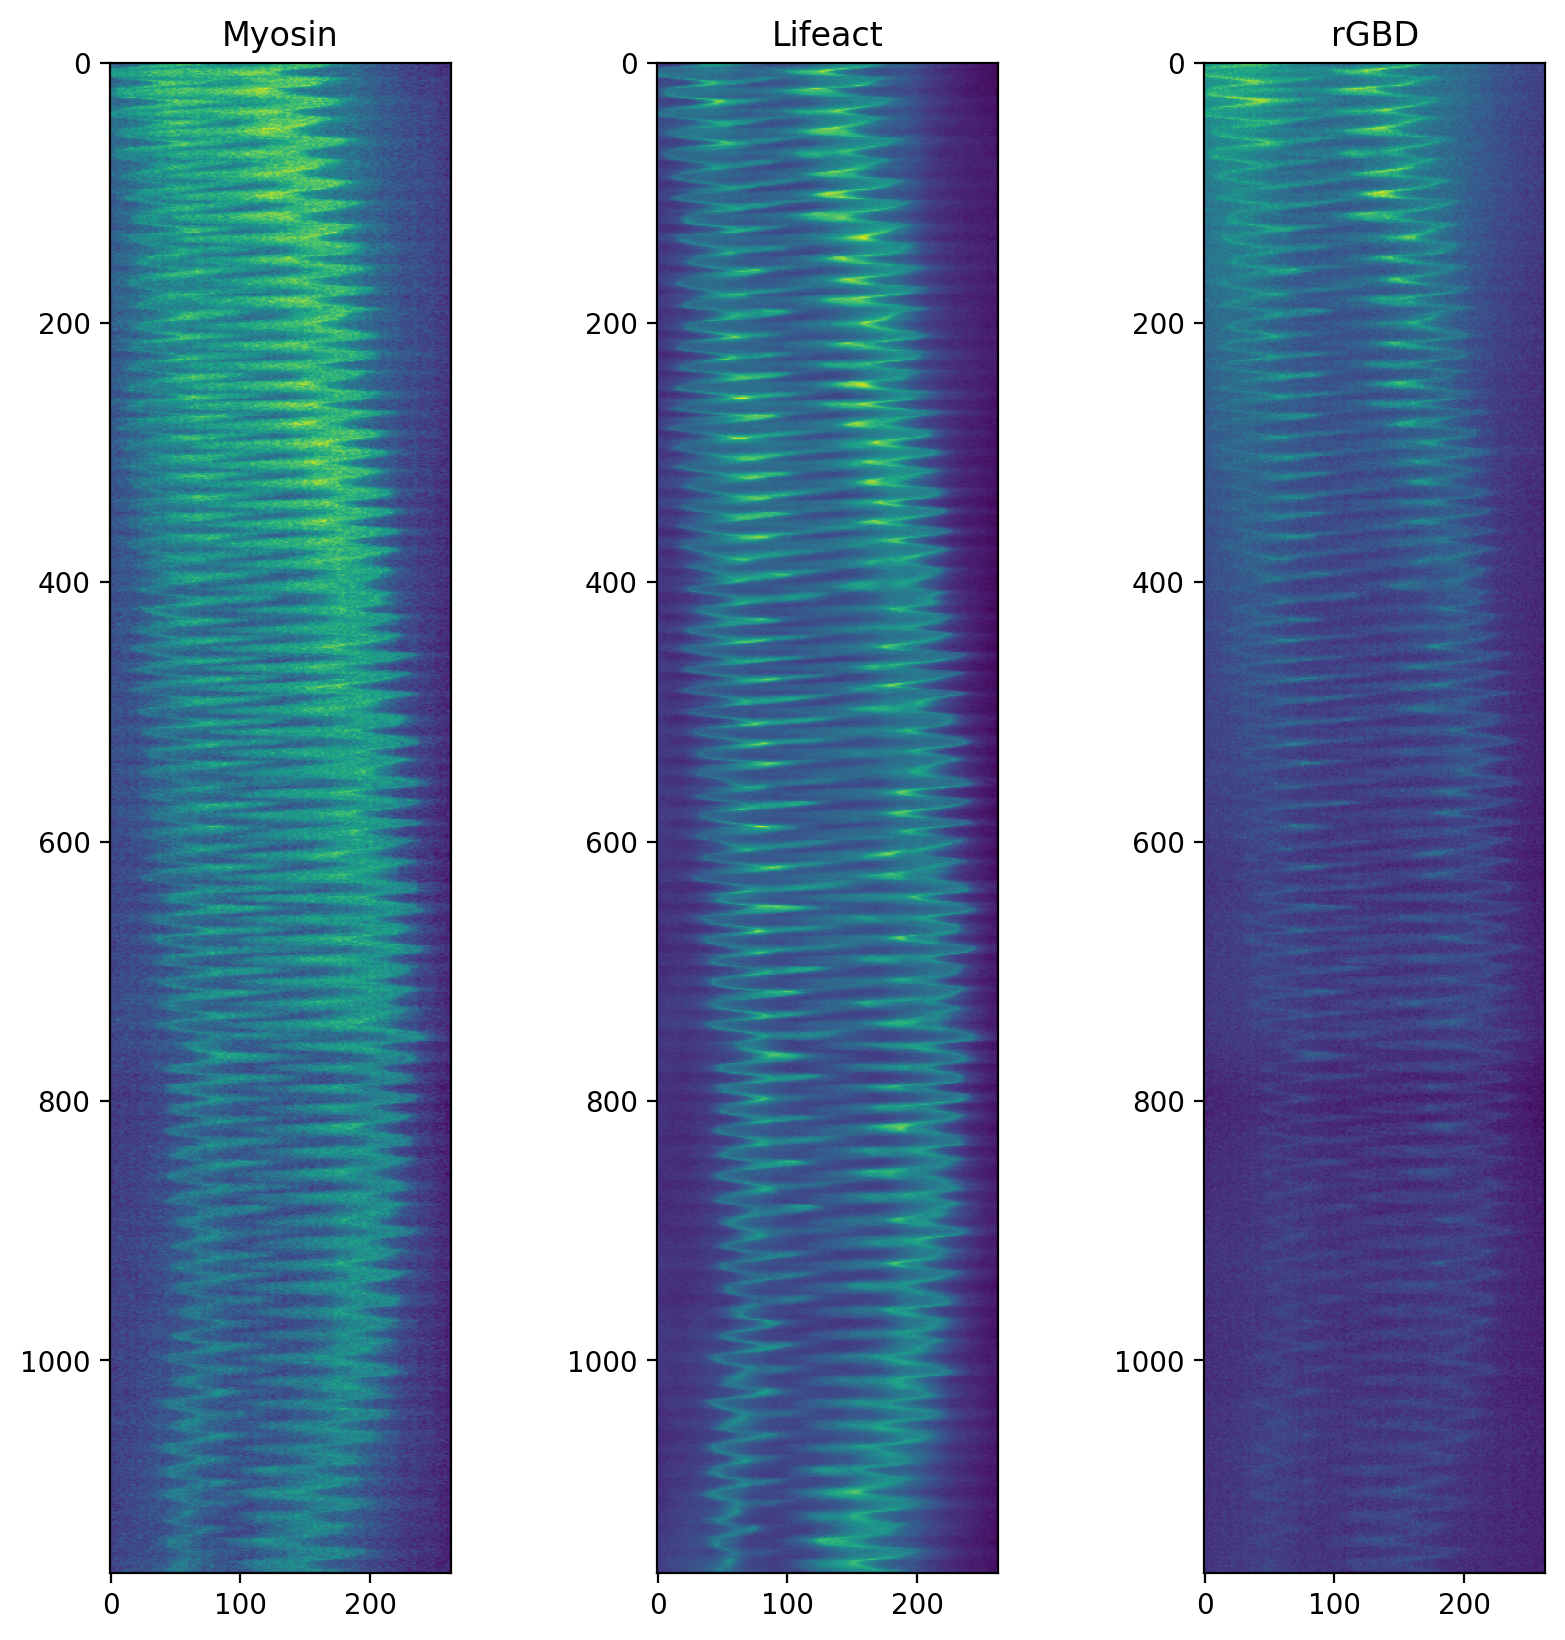

In [16]:
import skimage.measure
import numpy as np
def create_kymograph(src,dst,stack,linewidth=1,reduce_func = np.nanmean):
    profiles = []
    for frame_nb in range(stack.shape[0]):
        profile = skimage.measure.profile_line(stack[frame_nb], src, dst, linewidth=linewidth, order=None, mode='constant', cval=np.nan, reduce_func=reduce_func)
        profiles.append(profile)
    kymograph = np.array(profiles)
    return kymograph

linewidth = 5

kymograph_c0 = create_kymograph(src,dst,stack_raw[:,:,:,0],linewidth=linewidth)
kymograph_c1 = create_kymograph(src,dst,stack_raw[:,:,:,1],linewidth=linewidth)
kymograph_c2 = create_kymograph(src,dst,stack_raw[:,:,:,2],linewidth=linewidth)

#kymograph_stim = create_kymograph(src,dst,stack_light[200:1300,:,:],linewidth=linewidth)

#kymographs = [kymograph_c0,kymograph_c1, kymograph_stim]
kymographs = [kymograph_c0,kymograph_c1,kymograph_c2]
#farred, YFP, mcherry
#kymographs = [normalize_kymograph_time(k) for k in kymographs]

names = ['Myosin','Lifeact','rGBD']

kymographs = np.array(kymographs)

fig, axs= plt.subplots(ncols = len(kymographs),figsize = (10,10),dpi = 200)
for i, kymograph in enumerate(kymographs):
    axs[i].imshow(kymograph)
    axs[i].set_title(names[i])

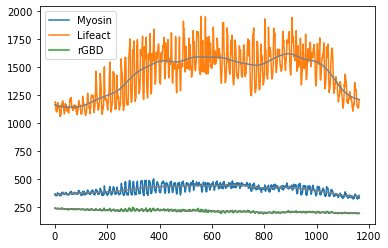

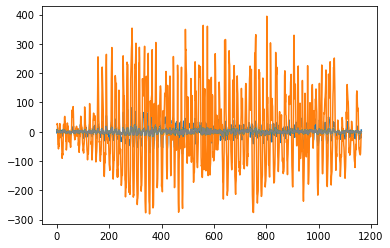

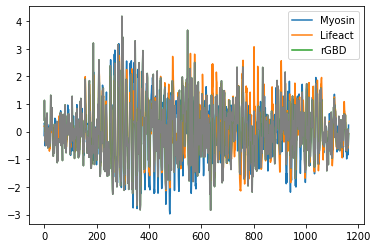

In [17]:
start_x = 200
stop_x = 210

signals = np.mean(kymographs[:,:,start_x:stop_x],axis = 2)
signals_gaussian = scipy.ndimage.gaussian_filter1d(signals, 30, axis =1, order=0, output=None, mode='nearest', cval=0.0, truncate=4.0)

for signal, name in zip(signals,names):
    plt.plot(signal,label=name)
for signal, name in zip(signals_gaussian,names):
    plt.plot(signal,c = 'gray')
plt.legend()
plt.show()

signals_detrend = signals-signals_gaussian
signals_std = np.std(signals_detrend,axis=1)
signals_norm = signals_detrend / signals_std[:,np.newaxis]

for signal, name in zip(signals_detrend,names):
        plt.plot(signal,label=name)
plt.plot(signal,c = 'gray')
plt.show()

for signal, name in zip(signals_norm,names):
        plt.plot(signal,label=name)
plt.plot(signal,c = 'gray')
plt.legend()
plt.show()

In [24]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

interp_factor = 5
spf = 5 #seconds per frame

nb_frames = signals.shape[1]
nb_channels = signals.shape[0]
timepoints = np.linspace(0,nb_frames*spf,nb_frames*interp_factor)

interp = np.linspace(0,nb_frames,nb_frames*interp_factor)

signals_interp = []
for channel in range(nb_channels):
    signal_interp = np.interp(interp, np.arange(nb_frames), signals_norm[channel,:])
    signals_interp.append(signal_interp)
signal_interp = np.array(signals_interp)

In [25]:
delay = int(1/3*interp_factor)
s1 = signals_interp[0][:-2*delay]
s2 = signals_interp[1][delay:-delay]
s3 = signals_interp[2][2*delay:]
print(len(s1))
print(len(s2))
print(len(s3))



signals_interp_crop = [s1,s2,s3]
signals_interp_crop = np.array(signals_interp_crop)

5818
5818
5818


In [26]:
signals_interp = signals_interp_crop
timepoints = np.linspace(0,nb_frames*spf,len(signals_interp[1]))


In [27]:
timepoints[crop_start:crop_stop]

array([], dtype=float64)

In [28]:
plt.rcParams.update({'font.sans-serif':'Arial'})


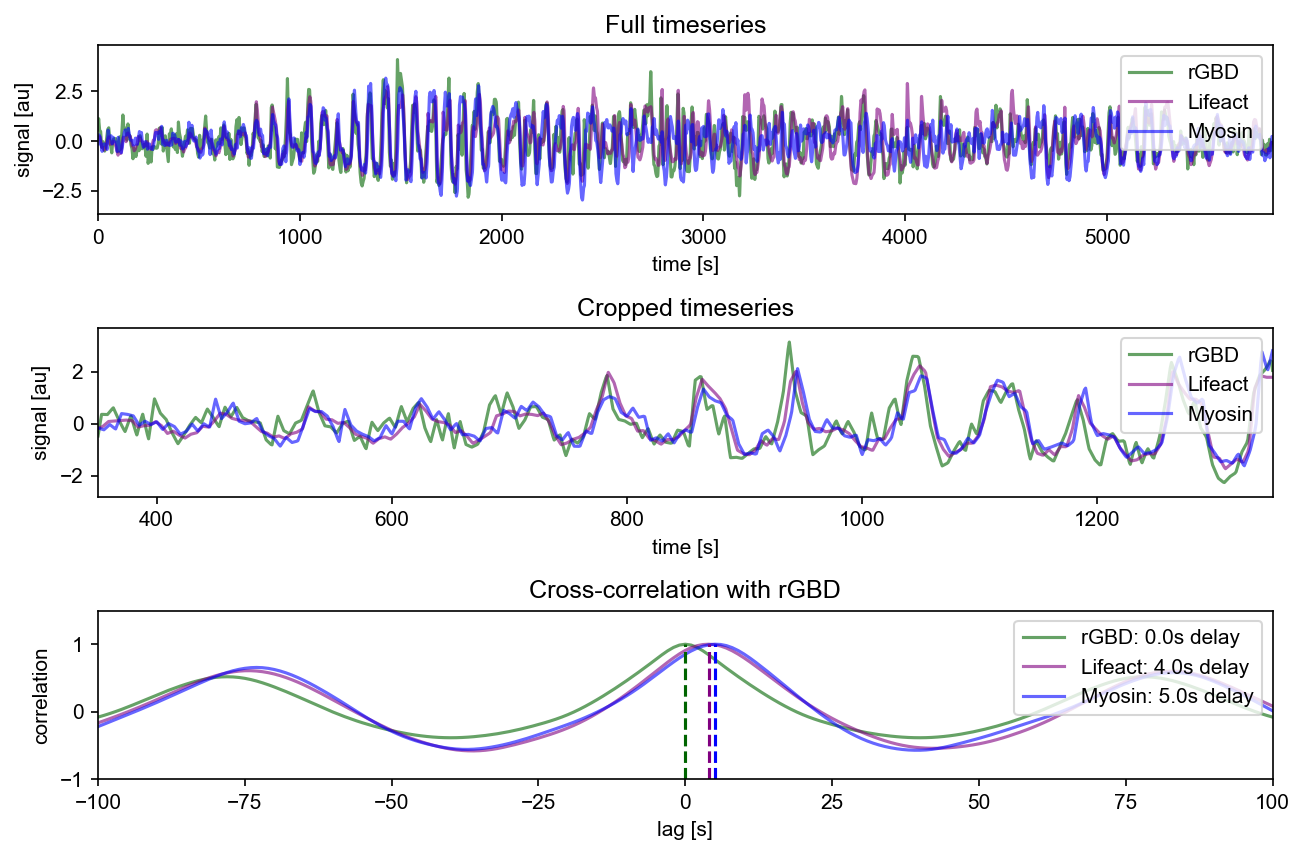

In [29]:
c_2 = 'darkgreen' #rGBD
c_1 = 'purple' #Lifeact
c_0 = 'blue' #Myosin

colors = [c_0,c_1,c_2]

sig = signals_interp[2]
sig_noise = signals_interp[1]
corr= signal.correlate(sig_noise, sig)
lags = signal.correlation_lags(len(sig), len(sig_noise))
corr /= np.max(corr)
corr_1 = corr

sig = signals_interp[2]
sig_noise = signals_interp[0]
corr = signal.correlate(sig_noise, sig)
lags = signal.correlation_lags(len(sig), len(sig_noise))
corr /= np.max(corr)
corr_0 = corr


sig = signals_interp[2]
sig_noise = signals_interp[2]
corr = signal.correlate(sig_noise, sig)
lags = signal.correlation_lags(len(sig), len(sig_noise))
corr /= np.max(corr)
corr_2 = corr


delay = lags[np.argmax(corr_0)]
delay_s_0 = delay/interp_factor*spf
delay = lags[np.argmax(corr_1)]
delay_s_1 = delay/interp_factor*spf
delay = lags[np.argmax(corr_2)]
delay_s_2 = delay/interp_factor*spf

delays = [delay_s_0,delay_s_1,delay_s_2]

fig, (ax_orig, ax_crop, ax_corr) = plt.subplots(3, 1, figsize=(8.8, 5.8),dpi = 150)

ax_orig.plot(timepoints,signals_interp[2],color = c_2,alpha = 0.6)
ax_orig.plot(timepoints,signals_interp[1],color = c_1,alpha = 0.6)
ax_orig.plot(timepoints,signals_interp[0],color = c_0,alpha = 0.6)
ax_orig.set_title('Full timeseries')
ax_orig.set_xlabel('time [s]')
ax_orig.set_ylabel('signal [au]')
ax_orig.legend([names[2],names[1],names[0]],loc='upper right')
ax_orig.margins(0, 0.1)


crop_start = 70 * interp_factor
crop_stop = 270 * interp_factor

ax_crop.plot(timepoints[crop_start:crop_stop],signals_interp[2][crop_start:crop_stop],color = c_2,alpha = 0.6)
ax_crop.plot(timepoints[crop_start:crop_stop],signals_interp[1][crop_start:crop_stop],color = c_1,alpha = 0.6)
ax_crop.plot(timepoints[crop_start:crop_stop],signals_interp[0][crop_start:crop_stop],color = c_0,alpha = 0.6)
ax_crop.set_title('Cropped timeseries')
ax_crop.set_xlabel('time [s]')
ax_crop.set_ylabel('signal [au]')
ax_crop.legend([names[2],names[1],names[0]],loc='upper right')
ax_crop.margins(0, 0.1)




ax_corr.plot(lags/interp_factor*5, corr_2,color = c_2,alpha = 0.6)
ax_corr.plot(lags/interp_factor*5, corr_1,color = c_1,alpha = 0.6)
ax_corr.plot(lags/interp_factor*5, corr_0,color = c_0,alpha = 0.6)

ax_corr.set_title('Cross-correlation with rGBD')
ax_corr.set_xlabel('lag [s]')
ax_corr.set_ylabel('correlation')
ax_corr.margins(0, 0.1)
ax_corr.set_xlim(-100,100)
ax_corr.set_ylim(-1,1.5)

ax_corr.legend([f'{channel}: {delay}s delay' for channel,delay in zip(names[::-1],delays[::-1])],loc='upper right')

ax_corr.vlines(delays,ymin = -1,ymax = 1,linestyles='dashed',colors=colors)

#ax_corr.text(x=15,y=1,s=f'max corr.: {delay_s}s')

fig.tight_layout()
plt.show()

In [30]:
### For causality analysis with ION


def create_extrema_csv(t_max, t_min):
    max_arr = np.array([intensities_maxima.T,np.repeat(1,len(intensities_maxima)).T])
    min_arr = np.array([intensities_minima.T,np.repeat(-1,len(intensities_minima)).T])
    df_max = pd.DataFrame(max_arr.T, columns=['time','e'])
    df_min = pd.DataFrame(min_arr.T, columns=['time','e'])
    df_e = pd.concat([df_max,df_min])
    df_e = df_e.sort_values(['time'])
    return df_e



e_dfs = []
for c in range(3):
    intensities_maxima = scipy.signal.find_peaks(signals_interp[c], distance=6)[0]
    intensities_minima = scipy.signal.find_peaks(signals_interp[c]*-1, distance=6)[0]
    df_e = create_extrema_csv(intensities_maxima,intensities_minima)
    df_e.to_csv(f'/Volumes/imaging.data/lhinder/code/bleb_oscillations/ION-main/Scripts/e{c+1}.csv',header=False,index=False)


df_matlab = pd.DataFrame()
df_matlab['time'] = np.arange(len(signals_interp[0]))
df_matlab['c0'] = signals_interp[0]
df_matlab['c1'] = signals_interp[1]
df_matlab['c2'] = signals_interp[2]


df_matlab.to_csv('/Volumes/imaging.data/lhinder/code/bleb_oscillations/ION-main/Scripts/data.csv',header=False,index=False)